# Çalışma

Bu çalışmada çeşitli transformer modellerini farklı ince ayar (finetuning) eğitim senaryoları için **doğrulama setindeki doğruluk skoru** üzerinden karşılaştırdık. Toplamda 216 farklı senaryo karşılaştırılmıştır.

## 1. Transformers 

Kullanılan transformer modelleri:
* [Multilingual BERT](https://github.com/google-research/bert) : Multilingual BERT, Google tarafından 104 dil için Wikipedia üzerinden eğitilmiş bir modeldir.
* [BerTurk](https://huggingface.co/dbmdz/bert-base-turkish-cased) : Stefan Schweter tarafından 35 GB'lık çeşitli Türkçe kaynaklardan oluşturularak eğitilmiş, BERT'in base modeli ile aynı büyüklüğe sahip bir modeldir.
* [Distilled (Damıtılmış) BerTurk](https://huggingface.co/dbmdz/distilbert-base-turkish-cased) : Yukarıdaki transformer modelinin, distillation [1] tekniğiyle başarımı ciddi seviyede korunarak, damıtılmış bir halidir.


Modellerin karşılaştırması:

|                   | Katman Sayısı | Kafa Sayısı | Saklı Katman Büyüklüğü | Toplam Parametre Sayısı |
|-------------------|:-------------:|:-----------:|:----------------------:|:-----------------------:|
| Multilingual BERT |       12      |      12     |           768          |           110M          |
| BerTurk           |       12      |      12     |           768          |           110M          |
| Distilled BerTurk |       6       |      12     |           768          |           66M           |


## 2. İyileştirici (Optimizer)

Çeşitli optimizerlar bu çalışmada denenmiştir:
* [AdamW](https://arxiv.org/pdf/1711.05101.pdf)
* [Adam](https://arxiv.org/pdf/1412.6980.pdf)
* [SGD](https://projecteuclid.org/euclid.aoms/1177729392)


## 3. Öğrenme Oranı & Kilo Kaybı (?) (Learning Rate & Weight Decay)

1e-3, 1e-4, 1e-5, 1e-6 öğrenme oranları ve 0, 0.01, 0.1 weight decay değerleri ince ayar senaryolarında araştırılmıştır.

## 4. Ön İşleme

Her ne kadar derin öğrenme tekniklerinin popülerleşmesiyle ön işleme (preprocessing) tekniklerinin önemi azalsa da bu çalışmada basit bir şekilde URL silmenin etkisi de incelenmiştir.


***

Türkçeleştirme Deep Learning Türkiye'nin sözlüğü referans alınarak yapılmıştır: https://github.com/deeplearningturkiye/turkce-yapay-zeka-terimleri/blob/master/ingilizce-turkce.md

In [1]:
import pandas as pd
import json
import os
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
results_path = "../../Turkish_Sentiment_Monitoring/Training/Results/"

In [3]:
# Sonuç json dosyalarını okumak için basit bir yardımcı fonksiyon
def read_result(fp):
    with open(fp, "r") as f:
        return json.load(f)

## Üst Değişken (Hyperparameter) Aramasında Ortalama Sonuçlara göre Karşılaştırma

In [4]:
all_results = []
columns = ["Transformer", "Optimizer", "Learning Rate", "Weight Decay", "Url Removal", "Training Loss", "Training Accuracy", "Training Recall", "Validation Accuracy", "Validation Recall"]
important_cols = ["Training Loss", "Training Accuracy", "Training Recall", "Validation Accuracy", "Validation Recall"]
for transformer in ["mbert", "berturk", "distilberturk"]:
    for folder in os.listdir(os.path.join(results_path, transformer)):
        temp = defaultdict(int)
        temp["Transformer"] = transformer
        temp["Optimizer"] = folder.split("_")[0]
        temp["Learning Rate"] = float(folder.split("_")[1])
        temp["Weight Decay"] = float(folder.split("_")[2])
        temp["Url Removal"] = len(folder.split("_"))>3
        count = 0
        for run in range(1, 4):
            try:
                current_run = read_result(os.path.join(results_path, transformer, folder, str(run)+".json"))
                current_run["Training Recall"] = current_run["Train Recall"]
                del current_run["Train Recall"]
                for col in important_cols:
                    temp[col] += current_run[col]
                count += 1

            except Exception as e:
                continue
        
        for col in important_cols:
            temp[col] /= count
        all_results.append(temp)

avg_results = pd.DataFrame(all_results).sort_values("Validation Accuracy", ascending = False)[columns].reset_index(drop=True)

Doğrulama setindeki doğruluk puanlarına (accuracy) göre modellerin sıralaması aşağıda görülmektedir.

Transformers bazlı modellerde oluşan varyans problemi [2] sebebiyle her bir durum **3 kez** çalıştırılıp, ortalaması alınmıştır.

In [5]:
avg_results

,Transformer,Optimizer,Learning Rate,Weight Decay,Url Removal,Training Loss,Training Accuracy,Training Recall,Validation Accuracy,Validation Recall
0,distilberturk,AdamW,0.000010,0.01,True,11.305967,0.951276,0.943315,0.712572,0.669722
1,distilberturk,AdamW,0.000010,0.01,False,17.660830,0.921856,0.909624,0.709442,0.665695
2,distilberturk,AdamW,0.000010,0.10,True,21.564664,0.904471,0.889830,0.706312,0.662225
3,distilberturk,AdamW,0.000010,0.00,True,11.838296,0.947730,0.938928,0.703182,0.662931
4,distilberturk,AdamW,0.000010,0.00,False,7.206128,0.969998,0.963908,0.703182,0.660954
...,...,...,...,...,...,...,...,...,...,...
211,distilberturk,SGD,0.000001,0.10,False,102.211427,0.276528,0.211107,0.271257,0.208449
212,distilberturk,SGD,0.000010,0.10,False,101.252340,0.241758,0.163677,0.247783,0.170341
213,berturk,SGD,0.000001,0.01,False,106.122190,0.230827,0.324540,0.245175,0.326893
214,berturk,Adam,0.000001,0.00,True,109.958505,0.225246,0.337146,0.243610,0.414862


## Transformer Modellerinin ve Optimizerların Etkisi

In [6]:
transformers = ["MBert", "BerTurk", "Distil BerTurk"]
optimizers = ["AdamW", "Adam", "SGD"]
tr_results = []
for transformer in ["mbert", "berturk", "distilberturk"]:
    temp = []
    for opt in optimizers:
        temp.append(avg_results.query(f"Transformer=='{transformer}' & Optimizer =='{opt}'").iloc[0]["Validation Accuracy"])
    tr_results.append(temp)

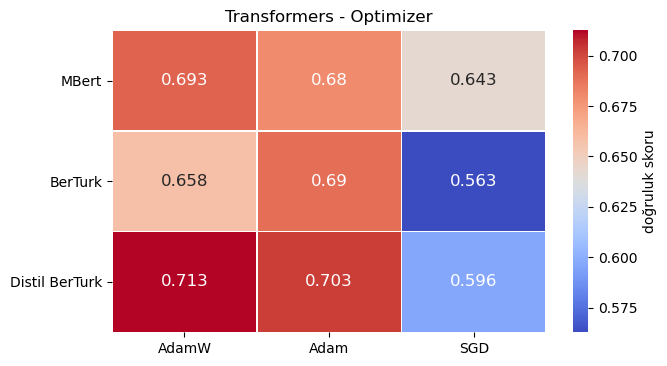

In [7]:
fig, ax = plt.subplots(figsize=(7, 4), dpi=100)
sns.heatmap(tr_results, xticklabels=optimizers, yticklabels=transformers, annot=True, linewidths=0.4,
            annot_kws={'size': 12}, cmap="coolwarm", fmt=".3", cbar_kws={'label': 'doğruluk skoru'}, ax=ax)
plt.title("Transformers - Optimizer")
plt.yticks(rotation=0) 
plt.show()

<font size="3">**Distilled(Damıtılmış) BerTurk** versiyonu en iyi sonucu veriyor ve aynı zamanda **AdamW** optimizer'ıyla da en iyi sonuçları alıyoruz.</font>

## Learning Rate ve Weight Decay Etkisi

In [8]:
lr = [0.001, 0.0001, 0.00001, 0.000001]
wd = [0, 0.01, 0.1]
transformer = "Distil BerTurk"
optimizer = "AdamW"
hyp_comp = []
for l in lr:
    temp = []
    for w in wd:
        temp.append(avg_results.query(f"Transformer=='distilberturk' & Optimizer =='{optimizer}' & `Learning Rate` == {l} & `Weight Decay`=={w}").iloc[0]["Validation Accuracy"])
    hyp_comp.append(temp)

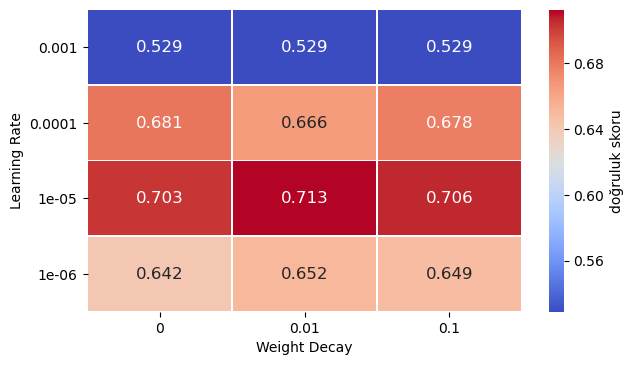

In [9]:
fig, ax = plt.subplots(figsize=(7, 4), dpi=100)
sns.heatmap(hyp_comp, xticklabels=wd, yticklabels=lr, annot=True, linewidths=0.4,
            annot_kws={'size': 12}, cmap="coolwarm", fmt=".3", cbar_kws={'label': 'doğruluk skoru'}, ax=ax)
plt.xlabel("Weight Decay")
plt.ylabel("Learning Rate")
plt.yticks(rotation=0) 
plt.show()

<font size="3">En iyi çalışan transformer modeli (Distilled BerTurk) için learning rate ve weight decay ise **0.00001** ve **0.01** için elde ediliyor.</font>

## Ön İşlemin Etkisi
Bu kısımda da ön işlem olarak url silmenin etkisini inceliyoruz.

In [10]:
transformer = "Distil BerTurk"
optimizer = "AdamW"
url_removal = ['True', 'False']
preprocessing = []
for url in url_removal:
    preprocessing.append(avg_results.query(f"Transformer=='distilberturk' & Optimizer =='{optimizer}' & `Url Removal` == {url}").iloc[0]["Validation Accuracy"])

print("Url'leri silerek:\t", np.round(preprocessing[0], 4))
print("Url'leri silmeden:\t", np.round(preprocessing[1], 4))

Url'leri silerek:	 0.7126
Url'leri silmeden:	 0.7094


***
En iyi modelimizde url silmenin etkisini az da olsa gözlemliyoruz. Belki eğitim veri sayısı daha fazla olsa bu fark daha da kapanabilir, transformer modeli daha iyi modelleyebilir.
Bu sonuçlarla beraber hyperparameter search'te en iyi sonuç veren model:

* Transformer: **Distil BerTurk**
* Optimizer: **AdamW**
* Learning Rate: **0.00001**
* Weight Decay: **0.01**
* Ön işlem: **Url Silmek**

### Referanslar
1. Victor Sanh, Lysandre Debut, Julien Chaumond, Thomas Wolf. 2019. [DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter.](https://arxiv.org/pdf/1910.01108.pdf) arXiv preprint arXiv:1910.01108.

2. Jesse Dodge, Gabriel Ilharco, Roy Schwartz, Ali Farhadi, Hannaneh Hajishirzi, and Noah Smith. 2020. [Fine-tuning pretrained language models: Weight initializations, data orders, and early stopping.](https://arxiv.org/pdf/2002.06305.pdf) arXiv preprint arXiv:2002.06305.